# This notebook contains code to register, fuse, segment, and track lightsheet data.

## Step 1: Export to Zarr format

In [16]:
# Fix for "No module named src" import error
import sys
import os
sys.path.append(os.path.abspath(".."))

from src.nucleus_dynamics.export_to_zarr.export_czi_to_zarr import export_czi_to_zarr, get_prefix_list
from src.build_killi.run00_get_frame_shifts import get_timeseries_shifts
from src.build_killi.run02_segment_nuclei import estimate_li_thresh, segment_nuclei, calculate_li_trend, calculate_li_thresh, do_hierarchical_watershed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from multiprocessing import freeze_support
import zarr
import napari

# Potentially temporary imports for segmentation threshold testing
import time
from skimage.filters import threshold_isodata, threshold_triangle, threshold_otsu, threshold_yen

Provide path and metadata info needed for export

In [8]:
resampling_scale = np.asarray([3, 0.85, 0.85]) # Resampling scale (um) for the data, in the order of (z, y, x)
tres = 101.11  # Time resolution (seconds). Pull this from the zarr metadata (info tab in zen)
overwrite = False  # If True, will overwrite existing zarr files. If False, will skip files that already exist.
par_flag = True  # If True, will use multiprocessing to speed up the export. If False, will run sequentially.

# set path to folder containing the raw czi files.
# E.g. for Syd's March movie this is "D:/Syd/250311_NLSxLCP1_26h_to_96h_R2/"
raw_data_root = "C:/Users/Sebastian/Documents/Research/killi_dynamics/raw_image_data/BC1/"  # Path to the folder containing the raw czi files. Make sure this is correct.

# Channel names for the data, in the order of the channels in the file. This is what we use to identify the channels in the zarr file.
channel_names = ["BC1", "nls"]

# Specify the path to the output zarr file
save_root = "C:/Users/Sebastian/Documents/Research/killi_dynamics/" # Output directory. Make sure there is sufficient space on the drive.

# Specify the project names for each side of the acquisition. These will be used for everything moving forward, so pick something interpretable.
# Date and protein-fluor at minimum
out_name_vec = ["BC1_NLS_test"]

Get list of file name prefixes for each side of the acquisition. Confirm that these are correct.

In [9]:
# Give string patterns to use to pick out frames from each side of the acquisition.
prefix_list = get_prefix_list(raw_data_root=raw_data_root)
prefix_list = [p for p in prefix_list if ".czi" not in p]
print(prefix_list)

['e1_2025_04_19__07_23_46_911_G1']


Now call the export function to export the data to zarr format.

In [17]:
resampling_scale = np.asarray([3, 0.85, 0.85])
for p, project_name in enumerate(out_name_vec):
    file_prefix = prefix_list[p]
    export_czi_to_zarr(raw_data_root, file_prefix, project_name, save_root, tres, par_flag=False,
                       resampling_scale=resampling_scale, channel_names=channel_names, overwrite_flag=False)

Exporting raw images to zarr...: 100%|██████████| 5/5 [19:08<00:00, 229.69s/it]

Done.


## Step 2: Registration

In [ ]:
get_timeseries_shifts(save_root, out_name_vec[0])

100%|██████████| 4/4 [41:04<00:00, 616.24s/it]


Visualize what shifts will be applied to the image so that the embryo will be centered in all frames.

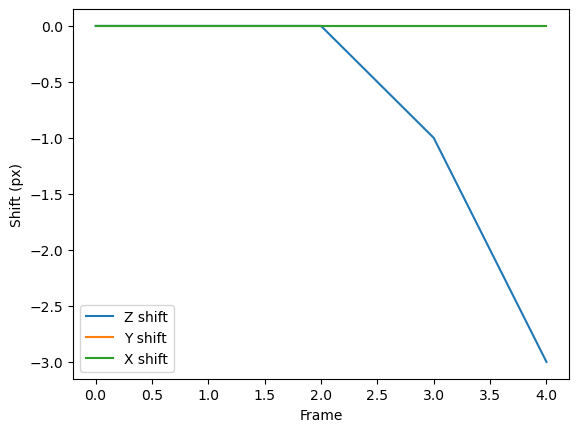

In [10]:
# Currently this will only plot for one half of the image if it is composed of two sides - out_name_vec[0] is the first half

csv_path = f"{save_root}metadata/{out_name_vec[0]}/frame_shift_df.csv"
frame_shifts = pd.read_csv(csv_path)

frames = frame_shifts["frame"].values
xs = frame_shifts["xs"].values
ys = frame_shifts["ys"].values
zs = frame_shifts["zs"].values

plt.plot(frames, zs, label="Z shift")
plt.plot(frames, ys, label="Y shift")
plt.plot(frames, xs, label="X shift")
plt.xlabel("Frame")
plt.ylabel("Shift (px)")
plt.legend()
plt.show()

In [ ]:
# Apply shifts

## Step 3: Segmentation

Calculate thresholds and apply masks

Li threshold: 324.961669921875
Triangle threshold: 33.29621124267578
Yen threshold: 161.2137451171875
Isodata threshold: -163.5
Otsu threshold: 387.5294189453125


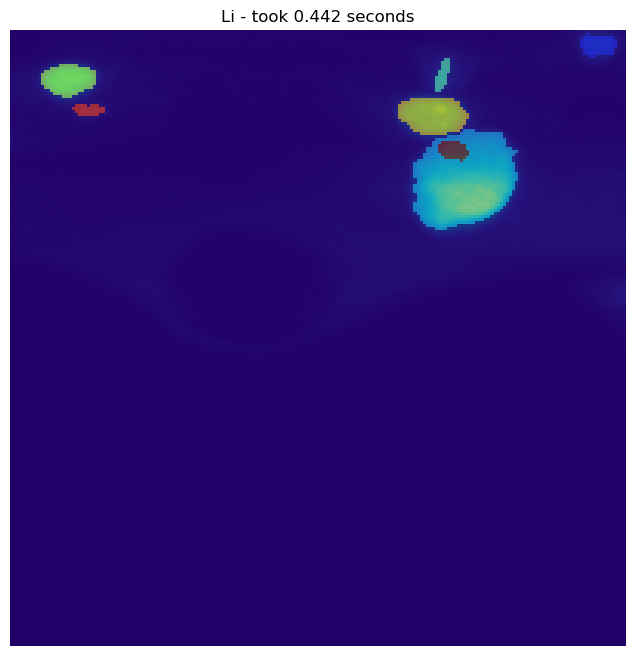

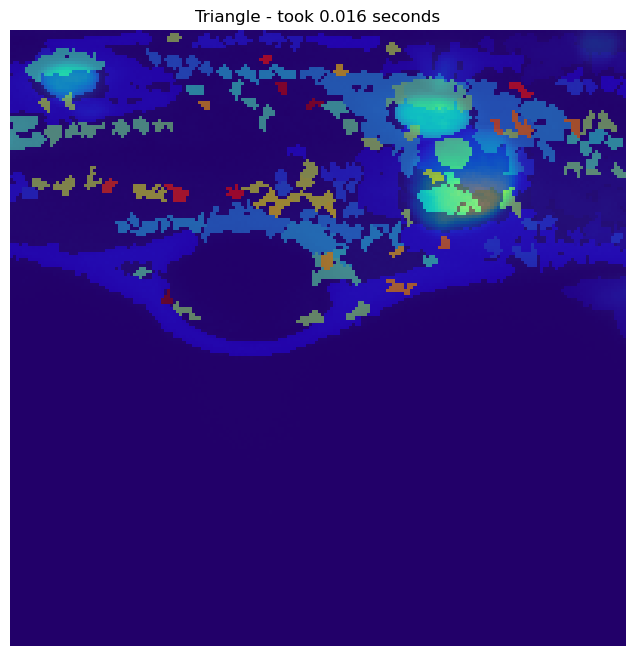

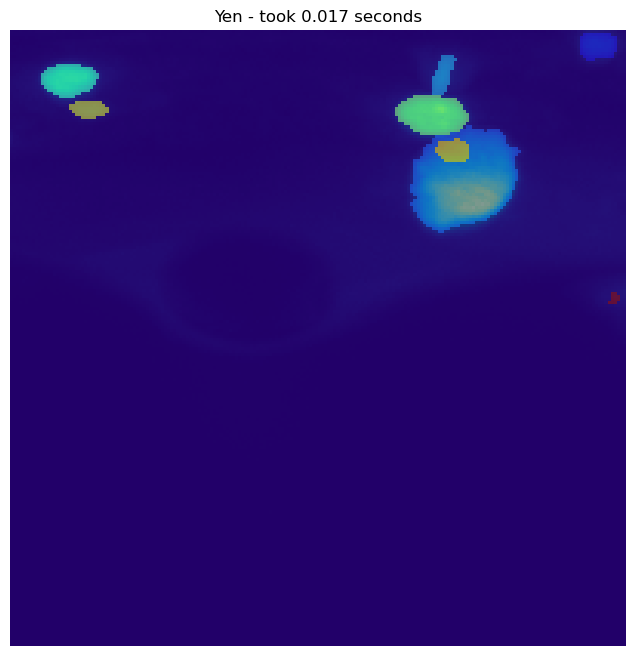

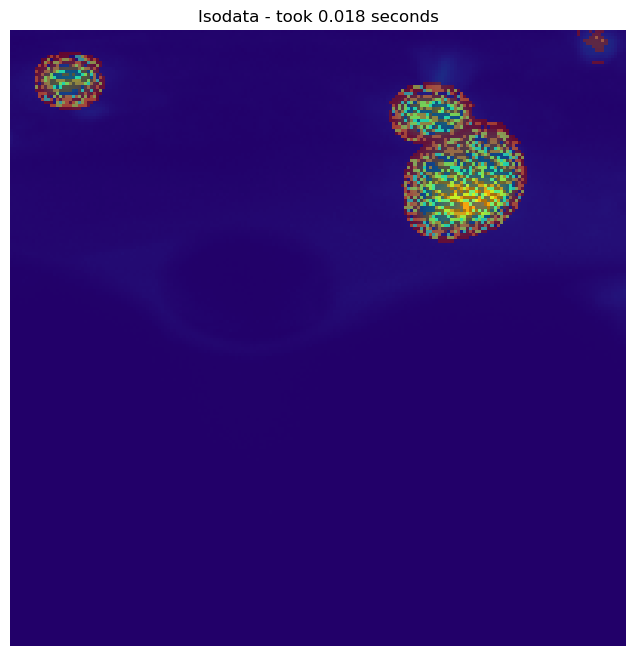

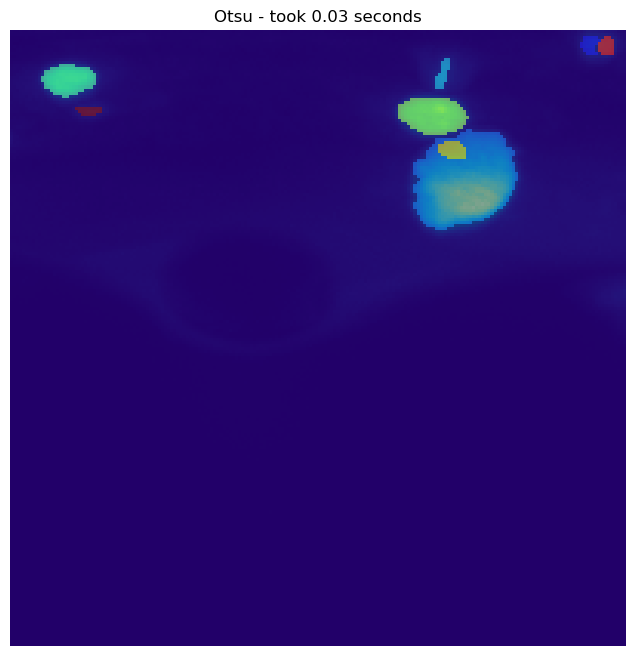

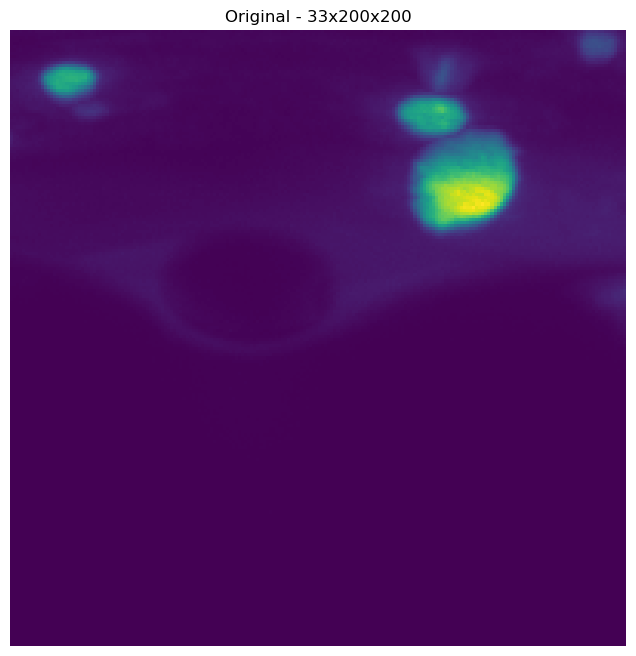

In [17]:
image_data = zarr.open("C:/Users/Sebastian/Documents/Research/killi_dynamics/built_data/zarr_image_files/BC1_NLS_test.zarr", mode="r")
im = image_data[2,1,100:133,100:300,600:800]

# default value for n_thresh is 5
n_thresh = 5

t1_li = time.time()
data_log_i, li_thresh = calculate_li_thresh(im)
t2_li = time.time()
li_thresh_range = np.linspace(li_thresh * 0.75, li_thresh * 1.25, n_thresh)
li_segmented, _ = do_hierarchical_watershed(data_log_i, thresh_range=li_thresh_range)

t1_tri = time.time()
triangle_thresh = threshold_triangle(data_log_i)
t2_tri = time.time()
triangle_thresh_range = np.linspace(triangle_thresh * 0.75, triangle_thresh * 1.25, n_thresh)
triangle_segmented, _ = do_hierarchical_watershed(data_log_i, thresh_range=triangle_thresh_range)

t1_yen = time.time()
yen_thresh = threshold_yen(data_log_i)
t2_yen = time.time()
yen_thresh_range = np.linspace(yen_thresh * 0.75, yen_thresh * 1.25, n_thresh)
yen_segmented, _ = do_hierarchical_watershed(data_log_i, thresh_range=yen_thresh_range)

t1_iso = time.time()
isodata_thresh = threshold_isodata(data_log_i)
t2_iso = time.time()
isodata_thresh_range = np.linspace(isodata_thresh * 0.75, isodata_thresh * 1.25, n_thresh)
isodata_segmented, _ = do_hierarchical_watershed(data_log_i, thresh_range=isodata_thresh_range)

t1_otsu = time.time()
otsu_thresh = threshold_otsu(data_log_i)
t2_otsu = time.time()
otsu_thresh_range = np.linspace(otsu_thresh * 0.75, otsu_thresh * 1.25, n_thresh)
otsu_segmented, _ = do_hierarchical_watershed(data_log_i, thresh_range=otsu_thresh_range)

print(f"Li threshold: {li_thresh}")
print(f"Triangle threshold: {triangle_thresh}")
print(f"Yen threshold: {yen_thresh}")
print(f"Isodata threshold: {isodata_thresh}")
print(f"Otsu threshold: {otsu_thresh}")

im_max = np.max(im, axis=0)
mask_max = np.max(im, axis=0)

plt.figure(figsize=(8,8))
plt.imshow(im_max)
segmented_max_li = np.max(li_segmented, axis=0)
plt.imshow(segmented_max_li, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title(f"Li - took {np.round(t2_li-t1_li, 3)} seconds")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(im_max)
segmented_max_triangle = np.max(triangle_segmented, axis=0)
plt.imshow(segmented_max_triangle, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title(f"Triangle - took {np.round(t2_tri-t1_tri, 3)} seconds")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(im_max)
segmented_max_yen = np.max(yen_segmented, axis=0)
plt.imshow(segmented_max_yen, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title(f"Yen - took {np.round(t2_yen-t1_yen, 3)} seconds")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(im_max)
segmented_max_isodata = np.max(isodata_segmented, axis=0)
plt.imshow(segmented_max_isodata, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title(f"Isodata - took {np.round(t2_iso-t1_iso, 3)} seconds")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(im_max)
segmented_max_otsu = np.max(otsu_segmented, axis=0)
plt.imshow(segmented_max_otsu, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title(f"Otsu - took {np.round(t2_otsu-t1_otsu, 3)} seconds")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(im_max)
plt.title("Original - 33x200x200")
plt.axis('off')
plt.show()

## Visualize with napari
This can be run after the raw CZI files are exported to Zarr format

In [4]:
zarr_path = os.path.join(save_root, "built_data", "zarr_image_files", out_name_vec[0] + ".zarr")
image_data = zarr.open(zarr_path, mode="r")
scale_vec = tuple([image_data.attrs['PhysicalSizeZ'],
         image_data.attrs['PhysicalSizeY'],
         image_data.attrs['PhysicalSizeX']])

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.squeeze(image_data[:]), channel_axis=0, scale=scale_vec)
napari.run()